In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
crawford_resnet50_path = kagglehub.dataset_download('crawford/resnet50')
alxmamaev_flowers_recognition_path = kagglehub.dataset_download('alxmamaev/flowers-recognition')

print('Data source import complete.')


100%|██████████| 174M/174M [00:10<00:00, 16.7MB/s]

Extracting files...


100%|██████████| 225M/225M [00:11<00:00, 19.9MB/s]

Extracting files...


Data source import complete.


In [2]:
import os

print(os.listdir(crawford_resnet50_path))
print(os.listdir())
print(os.listdir(alxmamaev_flowers_recognition_path))
print(os.listdir())



['resnet50_weights_tf_dim_ordering_tf_kernels.h5', 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 'imagenet_class_index.json']
['.config', 'sample_data']
['flowers']
['.config', 'sample_data']


# **1. Import Libraries**

In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from IPython.display import Image, display

In [4]:
import tensorflow as tf
print("TensorFlow:", tf.__version__)
print("Keras:", tf.keras.__version__)

TensorFlow: 2.19.0
Keras: 3.10.0


# **2. Dataset and Pretrained Weights**

In [5]:
# Path to pretrained ResNet50 weights (without the top fully-connected layer)
#resnet_weights_path = '/kaggle/input/crawford_resnet50_path/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
weights_path = os.path.join(crawford_resnet50_path, "resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

# Path to flower dataset (organized by folders: daisy/, rose/, tulip)
dataset_path = '/kaggle/input/flowers-recognition/flowers'

In [7]:
print(weights_path)
print(dataset_path)

/root/.cache/kagglehub/datasets/crawford/resnet50/versions/2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
/kaggle/input/flowers-recognition/flowers


# **3. Data Augmentation (to prevent overfitting)**

In [9]:
dataset_path = os.path.join(alxmamaev_flowers_recognition_path, "flowers")

In [10]:
data_generator = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.4,
    height_shift_range=0.4,
    zoom_range=0.3,
    rotation_range=20,
    validation_split=0.2   # 20% for validation
)
# Image size and batch size
image_size = 224
batch_size = 10

# Training generator (80% of data)
train_generator = data_generator.flow_from_directory(
    dataset_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Validation generator (20% of data)
val_generator = data_generator.flow_from_directory(
    dataset_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

num_classes = len(train_generator.class_indices)

Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


# **4. Build Model (Transfer Learning with ResNet50)**

In [12]:
model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights="imagenet"))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

model.layers[0].trainable = False
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,907,845 (114.09 MB)

 Trainable params: 6,309,893 (24.07 MB)

 Non-trainable params: 23,597,952 (90.02 MB)

# **5. Train the Model**

In [14]:
history = model.fit(
    train_generator,
    steps_per_epoch=int(train_generator.samples / batch_size),
    validation_data=val_generator,
    validation_steps=int(val_generator.samples / batch_size),
    epochs=10
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 85s 205ms/step - accuracy: 0.6118 - loss: 1.8745 - val_accuracy: 0.7837 - val_loss: 0.6250
Epoch 2/10
  1/345 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.7000 - loss: 0.7870

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


345/345 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7000 - loss: 0.7870 - val_accuracy: 0.7686 - val_loss: 0.6203
Epoch 3/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 61s 176ms/step - accuracy: 0.7330 - loss: 0.7523 - val_accuracy: 0.8035 - val_loss: 0.5509
Epoch 4/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7000 - loss: 0.7987 - val_accuracy: 0.8128 - val_loss: 0.5764
Epoch 5/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 62s 179ms/step - accuracy: 0.7558 - loss: 0.6916 - val_accuracy: 0.7814 - val_loss: 0.5956
Epoch 6/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.9000 - loss: 0.3460 - val_accuracy: 0.7674 - val_loss: 0.6061
Epoch 7/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 61s 178ms/step - accuracy: 0.7874 - loss: 0.6220 - val_accuracy: 0.8174 - val_loss: 0.5338
Epoch 8/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.9000 - loss: 0.3300 - val_accuracy: 0.8128 - val_loss: 0.5451
Epoch 9/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 70s 203ms/step - accuracy: 0.7951 - loss: 0.5929 - val_acc

In [15]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


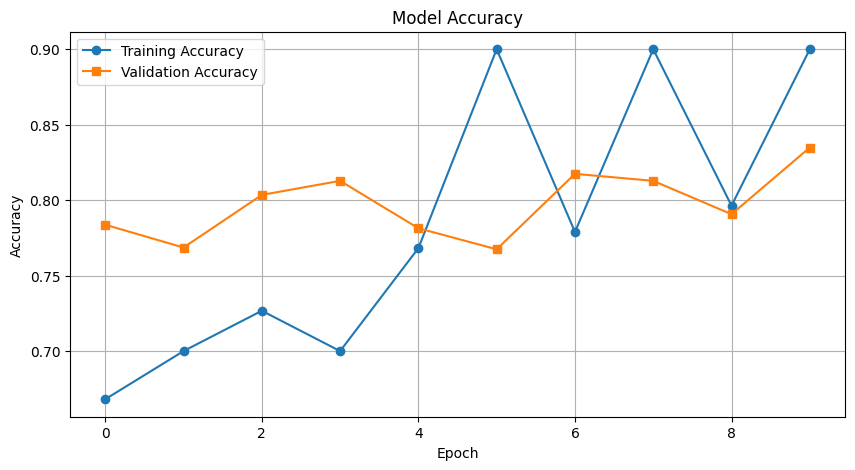

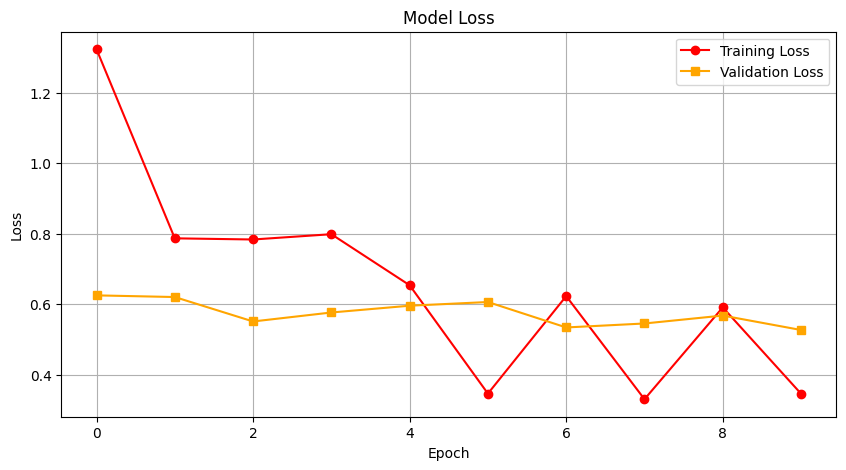

In [17]:
# Accuracy plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss', marker='o', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.legend()
plt.grid(True)
plt.show()

# **6. Test on Random Images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


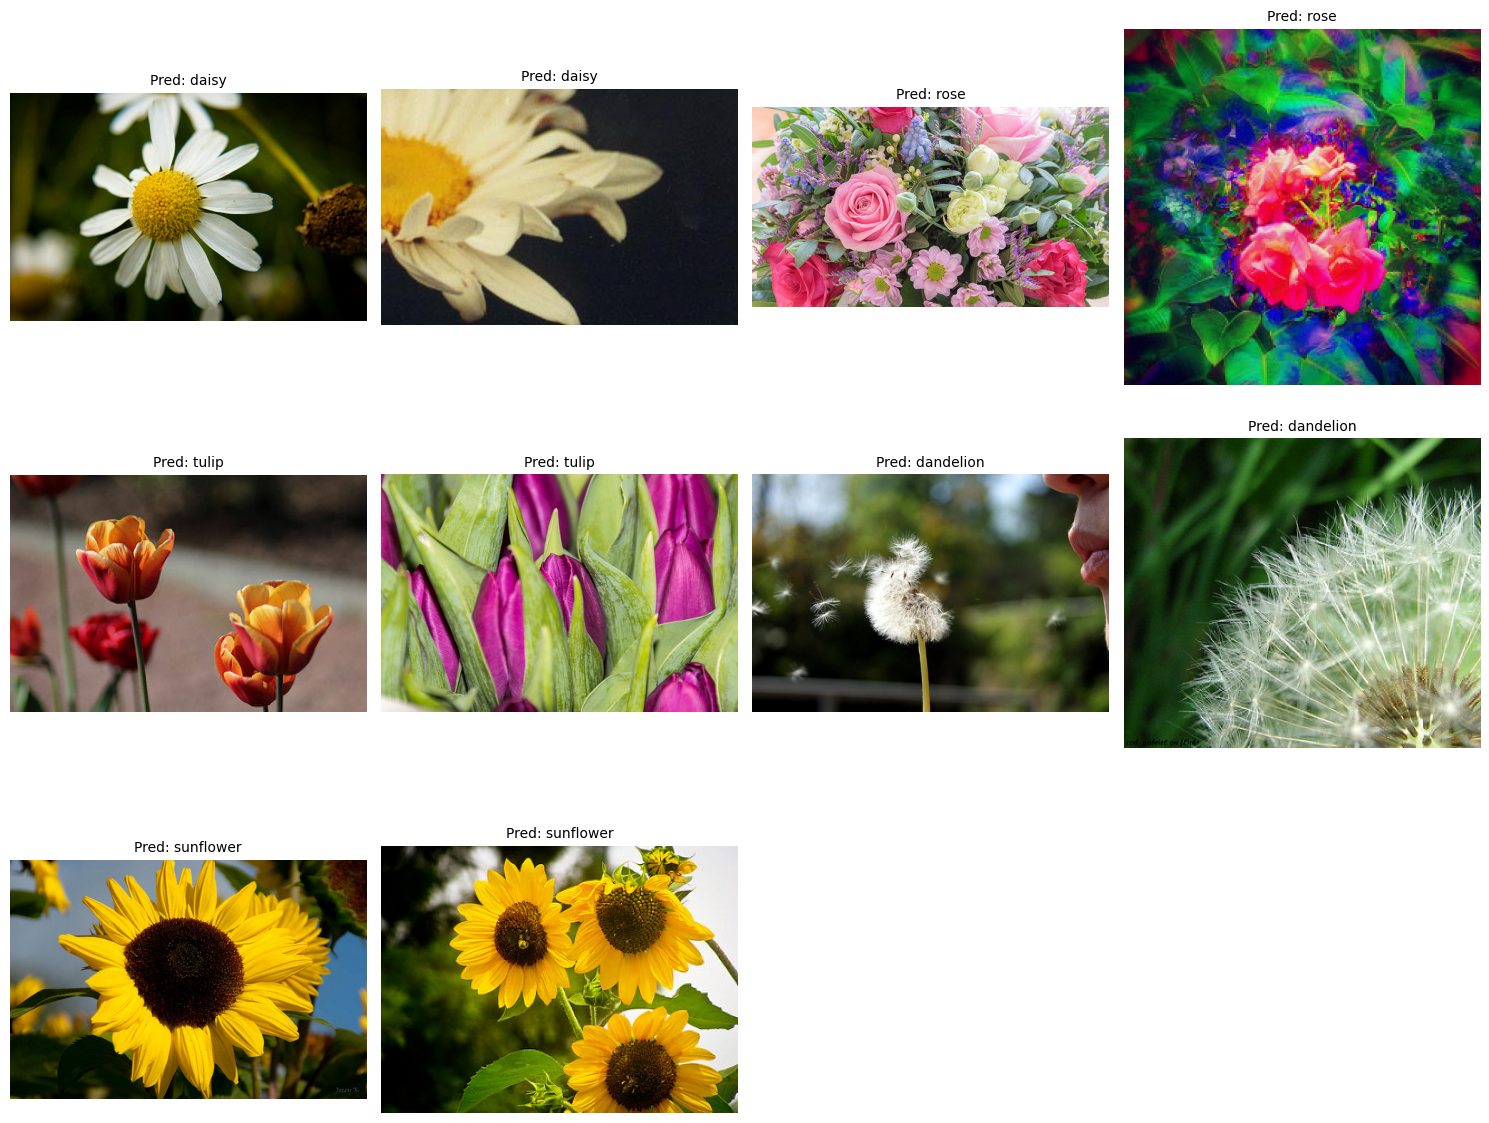

In [18]:
import math
import os
import random
import numpy as np
# Collect random images from dataset
img_locations = []
for d in os.listdir(dataset_path):
    directory = os.path.join(dataset_path, d)
    sample = [os.path.join(directory, s) for s in random.sample(os.listdir(directory), 2)]  # pick 2 per class
    img_locations += sample

# Function to preprocess test images
def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    return preprocess_input(img_array)


# Prepare and predict
imgs = read_and_prep_images(img_locations)
predictions = model.predict(imgs)

# Convert predictions to class names
predicted_classes = np.argmax(predictions, axis=1)
classes = {v: k for k, v in train_generator.class_indices.items()}


# Number of images
num_images = len(img_locations)

# Grid size (rows, cols)
cols = 4  # number of images per row
rows = math.ceil(num_images / cols)

plt.figure(figsize=(15, rows * 4))

for i, (img_path, pred) in enumerate(zip(img_locations, predicted_classes)):
    plt.subplot(rows, cols, i + 1)

    # Load original image for display (not resized)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.axis("off")

    # Set predicted label as title
    plt.title(f"Pred: {classes[pred]}", fontsize=10)

plt.tight_layout()
plt.show()

In [19]:
print(predicted_classes)

[0 0 2 2 4 4 1 1 3 3]


In [20]:
print(classes)

{0: 'daisy', 1: 'dandelion', 2: 'rose', 3: 'sunflower', 4: 'tulip'}


In [21]:
model.save("flower_model.h5")

In [22]:
model.save('my_model.keras')

In [29]:
import tensorflow as tf
import keras
import sys
import numpy as np

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("NumPy version:", np.__version__)
print("python version:", sys.version)

TensorFlow version: 2.19.0
Keras version: 3.10.0
NumPy version: 2.0.2
python version: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
